In [ ]:
## 데이터 전처리 

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# 그래프에서 한글깨짐 현상 수정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.getcwd()
os.chdir('/content/drive/MyDrive/Colab Notebooks')
os.listdir()

['Part 1 - 머신러닝 분류 모델',
 'ch14.ipynb',
 'adp_test',
 'fifa.ipynb',
 'preprocessing',
 '패스트캠퍼스',
 '(중앙학원)그래프와 시각화.ipynb',
 '(중앙학원)데이터 정제 및 준비.ipynb',
 'data',
 'adp 스케쥴.txt',
 'cheat sheet',
 '(중앙학원)데이터집계와 그룹연산.ipynb',
 '(중앙학원)시계열데이터 다루기.ipynb',
 '(중앙학원)고급pandas.ipynb',
 '(중앙학원)데이터 분석 예제.ipynb',
 '데이터 전처리.ipynb']

# 실습 1. 주문서 정리하기

In [ ]:
# 월별 매출 데이터 사용
# 각 시트에 월별 매출 기록되어 있음
# 필요없는 부분있으므로 삭제 후 데이터 통합(인란 등)

## **Step 1. 데이터 병합하기**

In [ ]:
sheet_names = [str(i+1) + '월' for i in range(12)]
sheet_names

['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']

In [ ]:
merged_df = pd.DataFrame()
for sn in sheet_names :
  df = pd.read_excel('월별매출데이터.xlsx', sheet_name=sn, skiprows=range(6)).iloc[:,1:] # 각 시트별 데이터를 필요없는 부분 잘라서 복사
  merged_df = pd.concat([merged_df, df], axis=0, ignore_index=True) # 각 페이지별로 있던 인덱스를 삭제하고 초기화 해둔 merged_df에 행방향 복사

In [ ]:
merged_df.info()
merged_df.head()
merged_df['일자'] # 데이터 포맷이 일정하지 않음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18229 entries, 0 to 18228
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   일자      18229 non-null  object
 1   지점      18229 non-null  object
 2   품명      18229 non-null  object
 3   수량      18229 non-null  int64 
 4   주문인 ID  18229 non-null  object
 5   수령 주소   18229 non-null  object
 6   주문 상태   18229 non-null  object
 7   결제 수단   18229 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.1+ MB


0          2018.1.1
1          2018.1.1
2          2018.1.1
3          2018.1.1
4          2018.1.1
            ...    
18224    2018-12-31
18225    2018-12-31
18226    2018-12-31
18227    2018-12-31
18228    2018-12-31
Name: 일자, Length: 18229, dtype: object

## **Step 2. 포맷 통일 및 변수 추가**

- 일자 컬럼의 포맷이 혼합되어 사용되고 있음
- 품명과 수량 컬럼을 바탕으로 주문 금액을 계산하여, 주문 금액이라는 컬름을 추가


> 주문금액 = 수량 X 가격 X 1.1(부가세)

- 제품에 따른 가격정보는 제품별_가격정보.xlsx에 정의되어 있음



In [ ]:
# str.replace를 활용하여 날짜 포맷 변경
merged_df['일자'] = merged_df['일자'].str.replace('.','-')
merged_df['일자']

0          2018-1-1
1          2018-1-1
2          2018-1-1
3          2018-1-1
4          2018-1-1
            ...    
18224    2018-12-31
18225    2018-12-31
18226    2018-12-31
18227    2018-12-31
18228    2018-12-31
Name: 일자, Length: 18229, dtype: object

In [ ]:
# 제품별 가격정보 파일 불러오기
price_df = pd.read_excel('제품별_가격정보.xlsx')
price_df

,제품,제품A,제품B,제품C,제품D,제품E,제품F
0,가격,20000,5000,10000,8000,30000,15000


In [ ]:
price_df = price_df.T
price_df

,0
제품,가격
제품A,20000
제품B,5000
제품C,10000
제품D,8000
제품E,30000
제품F,15000


In [ ]:
price_df.iloc[1: , 0]

제품A    20000
제품B     5000
제품C    10000
제품D     8000
제품E    30000
제품F    15000
Name: 0, dtype: object

In [ ]:
# Series의 to_dict함수를 사용하여 필요한 부분 dict형으로 변환, 인덱스가 키가 된다
price_dict = price_df.iloc[1: , 0].to_dict()
price_dict

{'제품A': 20000,
 '제품B': 5000,
 '제품C': 10000,
 '제품D': 8000,
 '제품E': 30000,
 '제품F': 15000}

In [ ]:
# Series의 replace 함수를 사용하면 dict 의 key에 해당하는 값을 value 값으로 변환 시킨다.(중요)
merged_df['가격'] = merged_df['품명'].replace(price_dict)

In [ ]:
merged_df['주문금액'] = merged_df['수량'] * merged_df['가격'] * 1.1 

In [ ]:
merged_df.head()

,일자,지점,품명,수량,주문인 ID,수령 주소,주문 상태,결제 수단,가격,주문금액
0,2018-1-1,지점1,제품B,3,C-168,서울특별시 동작구 흑석동,주문완료,인터넷뱅킹,5000,16500.0
1,2018-1-1,지점2,제품F,8,C-87,서울특별시 서대문구 신촌동,배송완료,신용카드,15000,132000.0
2,2018-1-1,지점4,제품B,2,C-158,서울특별시 종로구 종로5가,배송완료,휴대폰결제,5000,11000.0
3,2018-1-1,지점3,제품D,7,C-307,서울특별시 서대문구 냉천동,주문완료,휴대폰결제,8000,61600.0
4,2018-1-1,지점2,제품E,9,C-342,서울특별시 종로구 묘동,배송완료,인터넷뱅킹,30000,297000.0


## **Step 3. 월별 매출 추이 파악**

- 일자 변수를 바탕으로 월을 추출한 뒤, 월을 x 축으로 주문 금액 및 품목별 주문 금액을 y축으로 하는 꺾은선 그래프를 그림

In [ ]:
# expand 옵션은 나온 리스트 결과물을 새로운 데이터 프레임으로 만들어준다. 그래서 인덱스로 검색후 시리즈로 변환가능(중요)
merged_df['월'] = merged_df['일자'].str.split('-', expand = True)[1].astype(int)

In [ ]:
df = merged_df.groupby(['월','품명'])[['주문금액']].sum()
df

주문금액
월  품명             
1  제품A   7392000.0
   제품B   8283000.0
   제품C  18722000.0
   제품D  23170400.0
   제품E  32010000.0
...            ...
12 제품B   6611000.0
   제품C  20350000.0
   제품D  21428000.0
   제품E  29667000.0
   제품F  25476000.0

[72 rows x 1 columns]

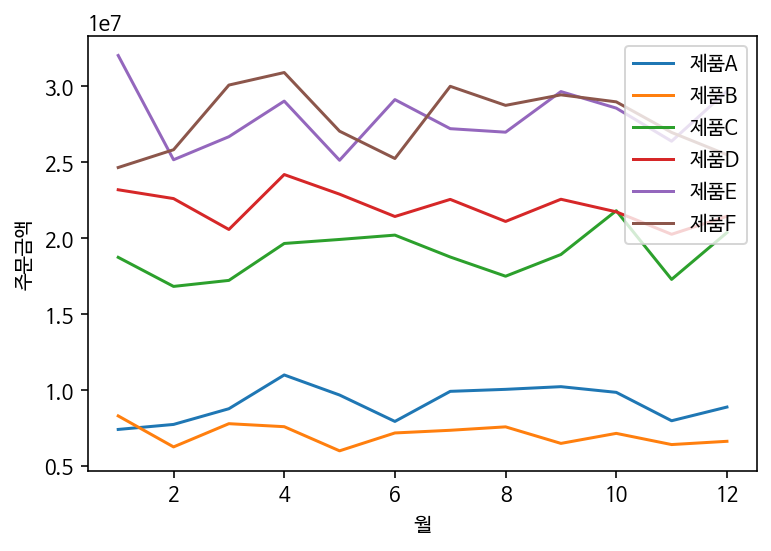

In [ ]:
# 내가 짠 코드
sns.lineplot(x = '월', y = '주문금액', hue = '품명',data = df )
plt.legend(loc = 'upper right')

In [ ]:
# 월과 품목에 따른 주문 금액 합계 계산
# 강의 코드
grouped_df_by_month = merged_df.groupby(['월'], as_index = False)['주문금액'].sum()
grouped_df_by_month_and_product = merged_df.groupby(['월', '품명'], as_index = False)['주문금액'].sum()

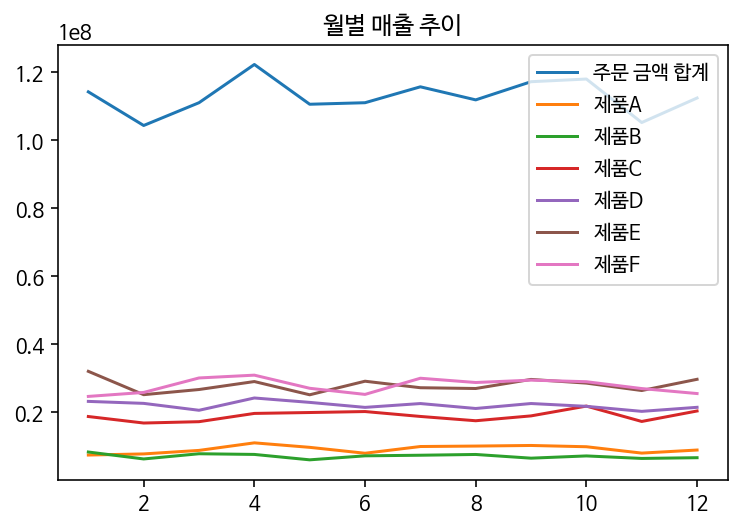

In [ ]:
plt.title("월별 매출 추이")
plt.plot(grouped_df_by_month['월'],
         grouped_df_by_month['주문금액'],
         label = "주문 금액 합계")

for product in grouped_df_by_month_and_product['품명'].unique():
    plt.plot(grouped_df_by_month_and_product['월'].unique(), # 월의 개수가 12 * 품목 개수라는 것에 주의
             grouped_df_by_month_and_product.loc[grouped_df_by_month_and_product['품명'] == product]['주문금액'], # 마스킹 검색            
             label = product)

plt.legend(loc = 'upper right')

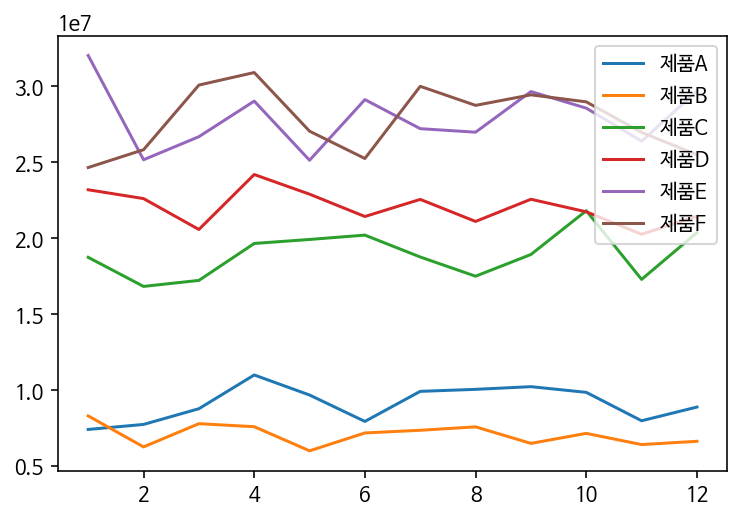

In [ ]:
for product in grouped_df_by_month_and_product['품명'].unique():
    plt.plot(grouped_df_by_month_and_product['월'].unique(), # 월의 개수가 12 * 품목 개수라는 것에 주의
             grouped_df_by_month_and_product.loc[grouped_df_by_month_and_product['품명'] == product]['주문금액'], # 마스킹 검색            
             label = product)

plt.legend(loc = 'upper right')

## **Step 4. 다양한 조건에 따른 판매 통계 분석**

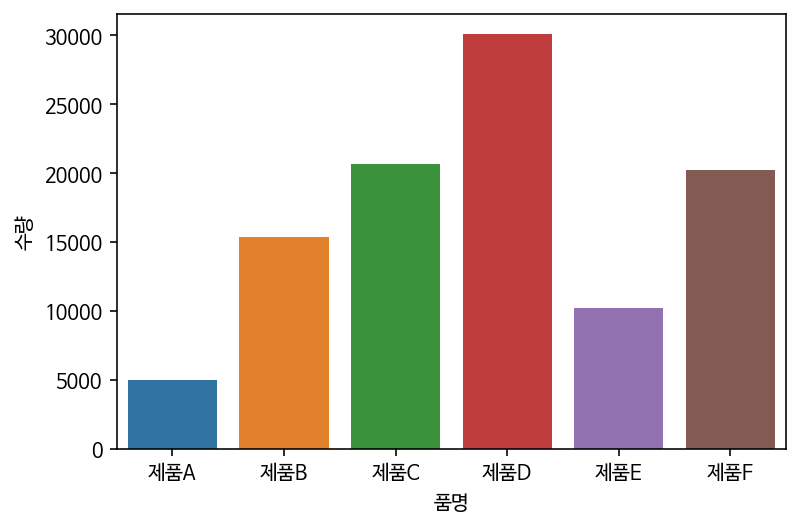

In [ ]:
# 제품별 판매량 통계
product_sold_sum = merged_df.groupby(['품명'])[['수량']].sum()
sns.barplot(x = product_sold_sum.index, y = '수량', data = product_sold_sum)

In [ ]:
# 제품과 결제 수단에 따른 판매량 분석
# 내가 쓴 코드
product_sold_how_sum = merged_df.groupby(['품명','결제 수단'])[['주문금액']].mean()
product_sold_how_sum = product_sold_how_sum.pivot_table(index= '품명', columns='결제 수단', values='주문금액')
product_sold_how_sum

결제 수단,무통장입금,신용카드,인터넷뱅킹,휴대폰결제
품명,,,,
제품A,119044.444444,130730.769231,118383.783784,130149.532710
제품B,31396.678967,30974.603175,31184.294872,30356.589147
제품C,58494.791667,59329.613095,60252.252252,62119.289340
제품D,49949.734513,48474.183351,48494.623656,49720.000000
제품E,188229.050279,184311.897106,186773.607748,200012.195122
제품F,93805.555556,90812.500000,92334.296724,91058.823529


In [ ]:
# 강의 코드
# pivot_table을 하면 값의 평균이 들어간다.(default = mean)
pivot_df = pd.pivot_table(merged_df, index='품명', columns='결제 수단', values='주문금액', aggfunc='mean')
pivot_df

결제 수단,무통장입금,신용카드,인터넷뱅킹,휴대폰결제
품명,,,,
제품A,119044.444444,130730.769231,118383.783784,130149.532710
제품B,31396.678967,30974.603175,31184.294872,30356.589147
제품C,58494.791667,59329.613095,60252.252252,62119.289340
제품D,49949.734513,48474.183351,48494.623656,49720.000000
제품E,188229.050279,184311.897106,186773.607748,200012.195122
제품F,93805.555556,90812.500000,92334.296724,91058.823529


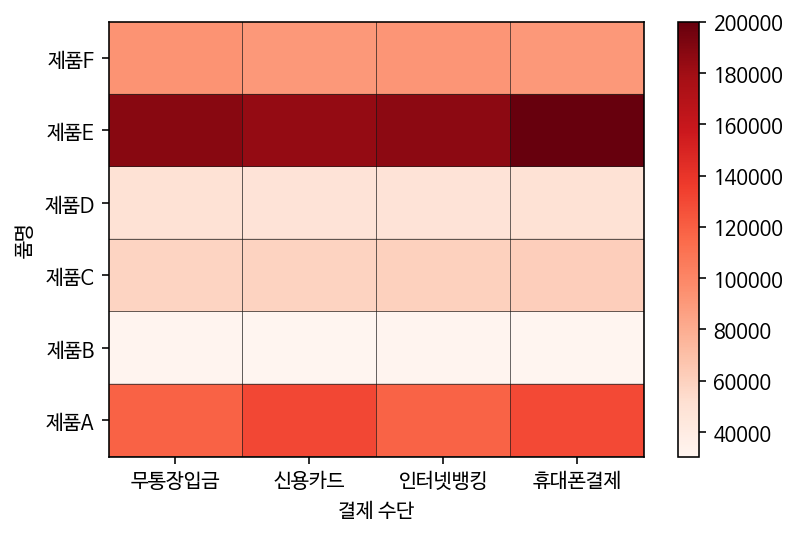

In [ ]:
# 강의 코드
plt.xlabel('결제 수단')
plt.ylabel('품명')

plt.xticks(np.arange(0.5, len(pivot_df.columns) + 1), pivot_df.columns)
plt.yticks(np.arange(0.5, len(pivot_df.index) + 1), pivot_df.index)

plt.pcolor(pivot_df, edgecolors = 'black', cmap = plt.cm.Reds)
plt.colorbar()

## **Step 5. 충성고객 찾기**

In [ ]:
# 주문 금액 합계 기준 상위 10% 고객 찾기
# 내가 짠 코드
cost_by_ID = merged_df.groupby(['주문인 ID'])['주문금액'].agg(['sum','count'])
cost_by_ID.sort_values(by=['sum','count'], ascending=False)[:int(0.1*len(cost_by_ID))]

,sum,count
주문인 ID,,
C-450,4759700.0,51
C-288,4640900.0,50
C-35,4453900.0,43
C-320,4313100.0,63
C-106,4276800.0,46
C-189,4250400.0,49
C-389,4171200.0,47
C-475,4012800.0,46
C-302,3974300.0,38


In [ ]:
# 주문 금액 합계 기준 상위 10% 고객 찾기 (가격과 구매 빈도 기준으로)
grouped_df_by_customer = merged_df.groupby('주문인 ID')['주문금액'].agg(['sum', 'count'])
grouped_df_by_customer

,sum,count
주문인 ID,,
C-0,1822700.0,34
C-1,2779700.0,36
C-10,2774200.0,34
C-100,3950100.0,46
C-101,2922700.0,32
...,...,...
C-95,3234000.0,41
C-96,2838000.0,39
C-97,2979900.0,31


In [ ]:
cond1 = grouped_df_by_customer['sum'].quantile(0.9)
cond2 = grouped_df_by_customer['count'].quantile(0.9)

grouped_df_by_customer[(grouped_df_by_customer['sum'] >= cond1) & (grouped_df_by_customer['count'] >= cond2)].sort_values(by=['sum','count'], ascending = False).head(10)


,sum,count
주문인 ID,,
C-450,4759700.0,51
C-288,4640900.0,50
C-320,4313100.0,63
C-106,4276800.0,46
C-189,4250400.0,49
C-389,4171200.0,47
C-475,4012800.0,46
C-439,3972100.0,50
C-100,3950100.0,46


In [ ]:
merged_df.head()

,일자,지점,품명,수량,주문인 ID,수령 주소,주문 상태,결제 수단,가격,주문금액,월
0,2018-1-1,지점1,제품B,3,C-168,서울특별시 동작구 흑석동,주문완료,인터넷뱅킹,5000,16500.0,1
1,2018-1-1,지점2,제품F,8,C-87,서울특별시 서대문구 신촌동,배송완료,신용카드,15000,132000.0,1
2,2018-1-1,지점4,제품B,2,C-158,서울특별시 종로구 종로5가,배송완료,휴대폰결제,5000,11000.0,1
3,2018-1-1,지점3,제품D,7,C-307,서울특별시 서대문구 냉천동,주문완료,휴대폰결제,8000,61600.0,1
4,2018-1-1,지점2,제품E,9,C-342,서울특별시 종로구 묘동,배송완료,인터넷뱅킹,30000,297000.0,1


In [ ]:
merged_df['주문 상태'].value_counts()

주문완료    6201
배송중     6098
배송완료    5930
Name: 주문 상태, dtype: int64

In [ ]:
#merged_df['월'] = merged_df['일자'].str.split('-', expand = True)[1].astype(int)
#merged_df['일자'].str.split('-', expand=True)[1]
merged_df['일자'].str.split('-', expand=True)

,0,1,2
0,2018,1,1
1,2018,1,1
2,2018,1,1
3,2018,1,1
4,2018,1,1
...,...,...,...
18224,2018,12,31
18225,2018,12,31
18226,2018,12,31
18227,2018,12,31


# 실습 2. 뉴스기사 요약하여 정리하기

월별 뉴스기사 수 추이 시각화, 주요 단어 추출, 월별 주요 단어 출현 빈도 시각화

1. 월별 뉴스 기사수의 합계를 바탕으로, 월별 뉴스 기사수의 합계의 추이를 나타내는 막대그래프를 그림

2. 기사 제목을 어절별로 구분한 뒤, 가장 자주 출현한 상위 10개의 단어와 그 빈도를 추출, 주요 단어와 그렇지 않은 단어의 출현 비율을 시각화

3. 뉴스 기사별로 주요 단어의 출현 여부를 계산하여, 월별 주요 단어 출현 빈도를 계산

In [ ]:
df = pd.read_csv(r"preprocessing/1. 데이터 핸들링/데이터/금융기사목록.csv", engine="python", encoding='cp949')
df.head()

,기사제목,신문사,작성일자
0,휴장일 슬쩍올빼미 공시 주의보,서울경제,2018-01-01
1,코스피 상단 28003100,서울경제,2018-01-01
2,한숨 동부대우전자 중동,서울경제,2018-01-01
3,금융투자업계 지도 생존 성장 운용자문사 대주주교체 카드 꺼내든다,파이낸셜뉴스,2018-01-01
4,금융투자업계 지도 모험자본 확충 원년 초대형 질주 계속,파이낸셜뉴스,2018-01-01


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6213 entries, 0 to 6212
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기사제목    6213 non-null   object
 1   신문사     6213 non-null   object
 2   작성일자    6213 non-null   object
dtypes: object(3)
memory usage: 145.7+ KB


### 내가 혼자 스스로 해보기

In [ ]:
df['날짜'] = df['작성일자']
for i in range(len(df)) :
  df['날짜'][i] = int(df['작성일자'].str.split('-')[i][1]) # 강의코드 보면 for문 안쓰고 적용

In [ ]:
news_per_month = df.groupby('날짜').count()['기사제목']
news_per_month = news_per_month.reset_index()

Text(0, 0.5, '뉴스 기사 수')

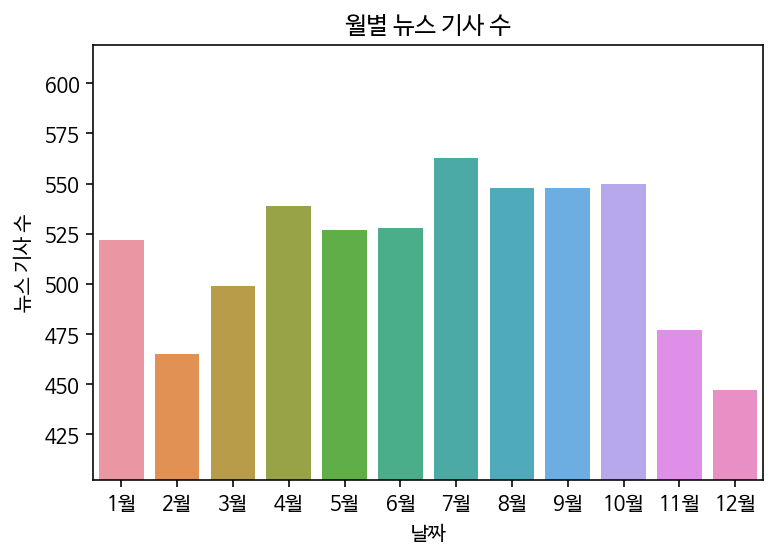

In [ ]:
sns.barplot(x='날짜', y = '기사제목', data=news_per_month)
plt.title('월별 뉴스 기사 수')
plt.xticks(range(12), [str(i+1) + '월' for i in range(12)])
plt.ylim([min(grouped_df['작성일자']) * 0.9, max(grouped_df['작성일자']) * 1.1])
plt.xlabel('날짜')
plt.ylabel('뉴스 기사 수')

In [ ]:
# 07:34 문제 2번
word_list = df['기사제목'].str.split().sum() # split한 후 sum을 하면 각각의 리스트로 출력이 아닌 하나의 리스트로 합해져서 보여진다.
word_list = pd.Series(word_list)
word_list.value_counts().head(10)

코스피     815
증시      745
상승      390
하락      350
코스닥     252
美       224
우려      215
마켓뷰     205
오전시황    190
환율      184
dtype: int64

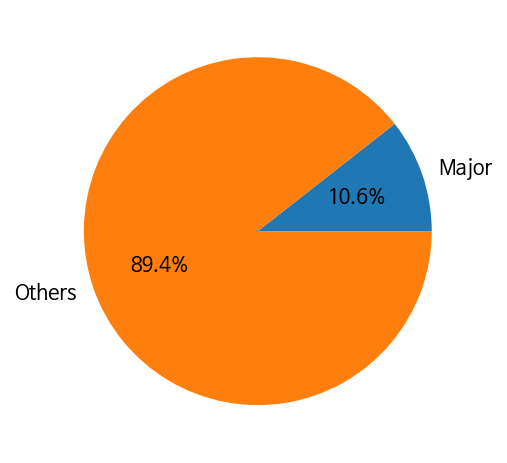

In [ ]:
# 최빈 단어 10개와 나머지 단어들의 비율 시각화

# 비율 구하기
total_word = word_list.value_counts().sum()
major_word = word_list.value_counts()[:10].sum()

ratio = [major_word / total_word, 1 - major_word / total_word]
labels = ['Major','Others']

plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

In [ ]:
# 뉴스 기사별로 주요 단어의 출현 여부를 계산하여, 월별 주요 단어 출현 빈도를 계산

major_word = word_list.value_counts().iloc[:10]

new_cols = []
for col in major_word.index:
  df[col] = df['기사제목'].str.contains(col) # str.contains 는 해당 문자열을 포함하는지 boolean 값으로 전달
  new_cols.append(col)

df.head()

,기사제목,신문사,작성일자,날짜,월,코스피,증시,상승,하락,코스닥,美,우려,마켓뷰,오전시황,환율
0,휴장일 슬쩍올빼미 공시 주의보,서울경제,2018-01-01,1,01,False,False,False,False,False,False,False,False,False,False
1,코스피 상단 28003100,서울경제,2018-01-01,1,01,True,False,False,False,False,False,False,False,False,False
2,한숨 동부대우전자 중동,서울경제,2018-01-01,1,01,False,False,False,False,False,False,False,False,False,False
3,금융투자업계 지도 생존 성장 운용자문사 대주주교체 카드 꺼내든다,파이낸셜뉴스,2018-01-01,1,01,False,False,False,False,False,False,False,False,False,False
4,금융투자업계 지도 모험자본 확충 원년 초대형 질주 계속,파이낸셜뉴스,2018-01-01,1,01,False,False,False,False,False,False,False,False,False,False


In [ ]:
monthly_major_word = df.groupby('날짜', as_index=False)[new_cols].sum()
monthly_major_word

,날짜,코스피,증시,상승,하락,코스닥,美,우려,마켓뷰,오전시황,환율
0,1,112,81,67,43,154,29,6,20,19,34
1,2,100,136,74,38,50,72,16,18,14,22
2,3,138,104,48,43,38,90,54,23,20,16
3,4,152,106,68,55,48,61,25,13,22,30
4,5,106,113,62,67,38,35,22,12,13,19
5,6,80,154,54,54,19,40,23,17,5,25
6,7,90,126,52,49,54,42,24,20,16,30
7,8,96,113,47,35,24,51,15,22,22,24
8,9,65,97,35,37,30,59,25,16,13,13
9,10,119,172,45,56,30,59,19,12,15,31


## 월별 뉴스기사 수 추이 시각화(강의 코드)

Text(0, 0.5, '뉴스 기사 수')

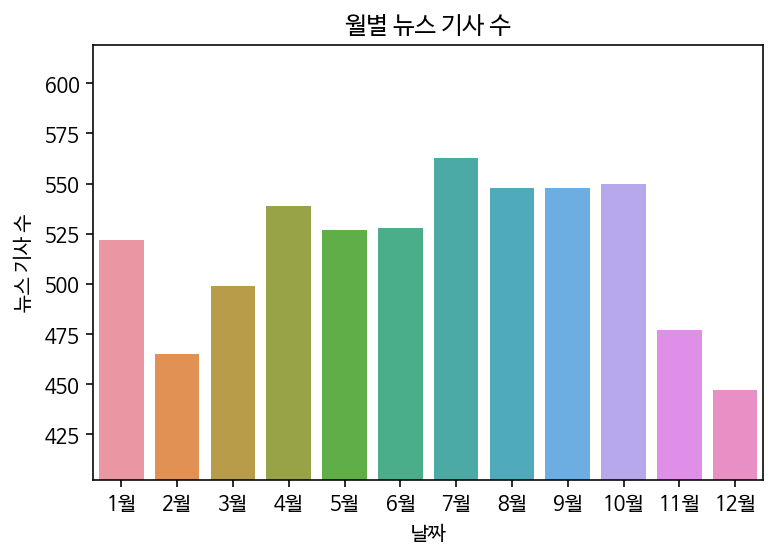

In [ ]:
df['월'] = df['작성일자'].str.split('-', expand=True)[1] # expand =True 하면 결과물이 시리즈가 아니라 데이터프레임으로 나옴, 자동인덱스 붙어서
grouped_df = df.groupby('월', as_index=False)['작성일자'].count() # as_index=False 는 인덱스로 만드는게 아니라 컬럼으로 만들어줌

# 시각화 할때 속성은 뒤에다 써주자
sns.barplot(x='월', y = '작성일자', data=grouped_df)
plt.title('월별 뉴스 기사 수')
plt.xticks(range(12), [str(i+1) + '월' for i in range(12)])
plt.ylim([min(grouped_df['작성일자']) * 0.9, max(grouped_df['작성일자']) * 1.1])
plt.xlabel('날짜')
plt.ylabel('뉴스 기사 수')

# 실습 3. 